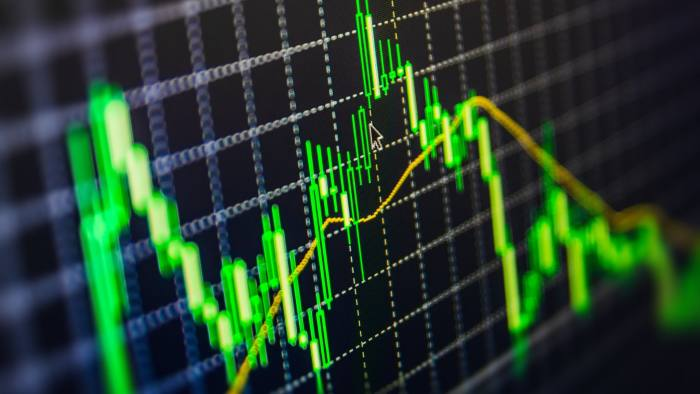
# Выпускной проект
## Предсказание котировок акции компании из Fortune-500
### Учащийся:      Александр Серебряков
### Ментор:        Сергей Медин
### Поток:         DST-15
### Месяц выпуска: Июль 2021

---

**Цель проекта**

Используя как можно более широкий спектр техник и знаний, полученных с помощью курса SkillFactory, создать модель для предсказания будущих котировок акций компании из списка Fortune 500.


**Методика**
* Для простоты эксперимента точность модели будем оценивать с помощью среднего абсолютного процентного отклонения (MAPE). Сведение отклонения к минимуму будет являться главной задачей проекта.
* Дополнительно рассчитаем упрощённую прибыльность в долларовом эквиваленте, хоть и ст*о*ит брать во внимание ряд ограничений такого подсчёта. А именно тот факт, что прибыльность существенно зависит от стратегии инвестирования, "скрывая" фактор влияния собственно модели МО. Также для реального рассчёта придётся прибыльности пойти на ряд дополнительных упрощений, из-за которых реальное значение может быть существенно иным (напр. мы не будем брать во внимание факторы трансакционных издержок, налогов, ликвидности рынка, дисконтирования и альтернативных возможностей вложения средств, использования рычага и т.д.).
* Результаты разных моделей будем сравнивать с "наивным" вариантом, основанном на гипотезе "случайного блуждания", которая с одинаковой вероятностью будет в ежедневном интервале приращивать / оставлять неизменным / убавлять значение предыдущего дня.
* В качестве "наивных" стратегий инвестирования будут взяты стратегия "покупай и держи" и "регулярных покупок" акций. Для доп. информации по прибыльности см. раздел 2.7.
* Автор в курсе гипотезы эффективного рынка и не строит иллюзий по поводу того, что на нынешнем этапе только и исключительно с помощью машинного обучения можно переиграть рынок в перспективе многих лет :)

## 1. Импорт библиотек и ключевые параметры

In [1]:
!pip install --upgrade pip
!pip install -q tensorflow
!pip install -q yfinance       # Для скачивания котировок с Yahoo! Finance
!pip install -q fbprophet      # Модель Facebook Prophet для анализа и предсказания врем. рядов
!pip install -q finvizfinance  # Библиотека для данных о торговле акций инсайдерами
!pip install -q flair          # Анализ "настроя" текста

     |████████████████████████████████| 1.5 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.


In [2]:
import yfinance as yf
import flair
from fbprophet import Prophet
from finvizfinance.quote import finvizfinance

import numpy as np
import pandas as pd
import tensorflow as tf

from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor
from statsmodels.tsa.arima.model import ARIMA
from scipy.interpolate import UnivariateSpline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.feature_selection import f_classif

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg' #графики в svg выглядят более четкими

import requests
import re
import sys
from datetime import datetime, timedelta

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1


In [4]:
# Подгружаем токен авторизации Твиттера

with open('/kaggle/input/twitter/twitter_token.txt', 'r') as twitter_token:
    BEARER_TOKEN = twitter_token.read()

In [5]:
TICKER      = 'DELL'

RANDOM_SEED = 42
TEST_SIZE   = 0.2

ITERATIONS  = 5000
LR          = 0.1

N_FOLDS     = 5
EPOCHS      = 100

PORTFOLIO    = 1000000
mape_dict = {}
pl_dict = {}

In [6]:
!pip freeze > requirements.txt

In [7]:
# Функция для подсчёта MAPE (kwargs - для использования в оценке кросс-валидации) и соответствующий оценщик.

def mape(y_true, y_pred, **kwargs):
    return np.mean(np.abs((y_pred-y_true)/y_true))

mape_scorer = make_scorer(mape, greater_is_better=False)

In [8]:
def display_results(y_true, y_pred, model_name):
    '''
        Общая функция, которая рисует график сравнения
        реальных и прогнозируемых данных и выводит
        значение MAPE.
         - y_true - реальные данные цены
         - y_pred - прогнозируемые данные цены
         - model_name - название модели (строка)
    '''
    global test_set_range
    global mape_dict
    
    mape_val = round(mape(y_true, y_pred) * 100, 2)
    mape_dict[model_name] = mape_val
    print(f'Значение отклонения MAPE - {model_name}: {mape_val}%')
    
    plt.plot(test_set_range, y_pred, color='blue', linestyle='dashed', label='Прогнозируемая цена')
    plt.plot(test_set_range, test_open, color='red', label='Реальная цена')

    plt.title(model_name)
    plt.xlabel('Дата')
    plt.ylabel('Цена')

    plt.yticks(np.arange(np.min(test_open), np.max(test_open), 10))

    plt.legend()
    plt.show();
    
    return None

In [9]:
def calc_profitability(y_pred, y_true, model_name, freq=5, costs=0):
    '''
        Функция, подсчитывающая прибыльность по методике,
        описанной выше.
         - y_pred - список с предсказанными значениями цены
         - y_true - список с реальными значениями цены
         - model_name - название модели (строка)
         - freq (по умолч. 5)- частота оценки и инвестирования в днях
         - costs - трансакционные издержки в % от цены продажи
    '''
    base_val = PORTFOLIO
    installment_count = int(len(test_data) / freq)

    for i in range(installment_count):
        cur_price_real = float(y_true[i * freq])         # Нынешняя цена
        fut_price_pred = float(y_pred[(i + 1) * freq])   # Предсказание цены через freq дней
        fut_price_real = float(y_true[(i + 1) * freq])   # Реальная цена через freq дней
        

        # Ожидаемая стоимость акции выше, чем нынешняя? Тогда покупаем акции на все деньги
        # и реализуем по более высокой цене, когда проходит freq кол-во дней.
        # Ниже? Тогда "одалживаем" акции и продаём их по спотовой цене, а затем покупаем и
        # возвращаем их после падения стоимости, фиксируя прибыль равной разнице в ценах.
        
        stock_count = base_val / cur_price_real
        
        if (fut_price_pred * (1 - costs)) > cur_price_real:
            base_val += (fut_price_real * (1 - costs) - cur_price_real) * stock_count
        else:
            base_val += (cur_price_real * (1 - costs) - fut_price_real) * stock_count
            
    profit = int(round(base_val - PORTFOLIO, 0))
    
    global pl_dict
    pl_dict[model_name] = profit
    print(f'Прибыльность стратегии {model_name}: ${pl_dict[model_name]}')
    
    return None

---
## 2. Первичный осмотр и предобработка данных

### 2.1 Загрузка данных

[*********************100%***********************]  1 of 1 completed


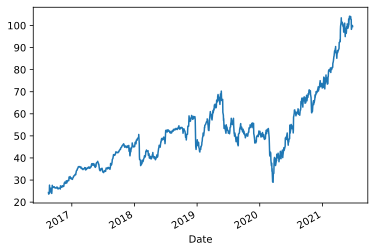

In [10]:
# Данные до августа 2016 недоступны, т.к. в 2013 компания была выкуплена
# частным инвестиционным фондом совместно с Майклом Деллом.
# В 2016 году после реструктуризации компания повторно вышла на биржу.

df = yf.download(TICKER, '2016-08-18', '2021-06-27')

df['Open'].plot()

plt.show();

In [11]:
# Смотрим размерность полученных данных и типы данных и пропуски.

print(df.shape, '\n')

df.info()

(1222, 6) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1222 entries, 2016-08-18 to 2021-06-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1222 non-null   float64
 1   High       1222 non-null   float64
 2   Low        1222 non-null   float64
 3   Close      1222 non-null   float64
 4   Adj Close  1222 non-null   float64
 5   Volume     1222 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 66.8 KB


Признаки, присутствующие в наборе:
* Open - котировка при открытии торгов;
* High - максимальная стоимость акции в течение дня;
* Low - минимальная стоимость акции в течение дня;
* Close - цена акции при закрытии торгов;
* Adj Close - цена акции при закрытии торгов с учётом сплитов и дивидендов;
* Volume - объём торгов за день.

Пропуски отсутствуют.

In [12]:
# Выборка данных.

df.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-15,88.739998,89.320000,88.220001,89.300003,89.300003,2849200
2018-02-22,38.936878,39.424141,38.648949,39.069767,39.069767,2852577
2016-10-10,26.616833,26.799557,26.218163,26.312292,26.312292,2747287
2018-09-12,53.433002,54.025471,53.205978,53.837208,53.837208,2604071
2019-07-23,56.700001,56.700001,54.639999,55.459999,55.459999,2300600


### 2.2 Корреляция признаков

In [13]:
df.corr().round(3)

,Open,High,Low,Close,Adj Close,Volume
Open,1.000,0.999,0.999,0.999,0.999,-0.089
High,0.999,1.000,0.999,0.999,0.999,-0.084
Low,0.999,0.999,1.000,0.999,0.999,-0.103
Close,0.999,0.999,0.999,1.000,1.000,-0.095
Adj Close,0.999,0.999,0.999,1.000,1.000,-0.095
Volume,-0.089,-0.084,-0.103,-0.095,-0.095,1.000


### 2.3 Дополнительные признаки

Дополним в наборе производные признаки, которые нам помогут в дальнейшем анализе.

In [14]:
# Разброс цен в течение дня
df['intraday_range'] = df['High'] - df['Low']

# Разница в цене при открытии и закрытии торгов
df['daily_range'] = df['Close'] - df['Open']

# Разница в цене при открытии торгов по сравнению с предыдущим днём
df['overnight_delta'] = df['Open'] - df['Adj Close'].shift(1)
df['overnight_delta'].iloc[0] = 0

# 25-дневные максимумы, минимумы и среднее
df['25day_max'] = df['High'].shift(1).rolling(window=25, min_periods=1).max()
df['25day_min'] = df['Low'].shift(1).rolling(window=25, min_periods=1).min()
df['25day_mean'] = df['Open'].shift(1).rolling(window=25, min_periods=1).mean()

df['25day_max'].iloc[0] = df['High'].iloc[0]
df['25day_min'].iloc[0] = df['Low'].iloc[0]
df['25day_mean'].iloc[0] = df['Open'].iloc[0]

# Достигли ли мы 25-дневного максимума и минимума соответственно? (1 - да, 0 - нет)
df['if_25day_max'] = np.where(df['High'] == df['25day_max'], 1, 0)
df['if_25day_min'] = np.where(df['Low'] == df['25day_min'], 1, 0)

# Средний объём и стандартное отклонение торгов за последнюю скользящую рабочую неделю (5 дней из-за выходных)
df['volume_7d_mean'] = df['Volume'].rolling(window=5, min_periods=1).mean()
df['volume_7d_std']  = df['Volume'].rolling(window=5, min_periods=1).std()
df['volume_7d_std'].iloc[0] = 0

# Разница в объёме торгов за день по сравнению со скользящей рабочей неделей
df['volume_7d_delta'] = df['Volume'] - df['volume_7d_mean']

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
# Кол-во дней с последнего максимума

df_max = df[['if_25day_max']][df['if_25day_max'] == 1]
df_max['max_days_delta'] = df_max.index.to_series().diff().dt.days.astype('Int32')
df_max['max_days_delta'].iloc[0] = 0
df_max.drop(['if_25day_max'], inplace=True, axis=1)


# Кол-во дней с последнего минимума

df_min = df[['if_25day_min']][df['if_25day_min'] == 1]
df_min['min_days_delta'] = df_min.index.to_series().diff().dt.days.astype('Int32')
df_min['min_days_delta'].iloc[0] = 0
df_min.drop(['if_25day_min'], inplace=True, axis=1)

In [16]:
# Объединяем с главным набором и заполняем пропуски нулями (дни, когда максимумов не было)

df = df.join(df_max, how='left')
df = df.join(df_min, how='left')


df['max_days_delta'].fillna(0, inplace=True)
df['min_days_delta'].fillna(0, inplace=True)

### 2.4 Торговые операции инсайдеров

В качестве дополнительной общедоступной информации будем также использовать новости о торговле акциями / использовании опционов инсайдерами из совета директоров и высшего менеджмента компании - по требованиям SEC, американского регулятора по ценным бумагам, такая информация публикуется и доступна общественности. Логика такого дополнительного анализа "настроя" достаточно проста - если инсайдеры будут замечены в распродаже своих акций, то есть причины считать, что цена будет падать, и наоборот - дополнительная закупка акций сигнализирует веру в будущий рост котировок.

Воспользуемся библиотекой finvizfinance, которая предоставляет данные последних 100 инсайдерских торговых операций.

https://pypi.org/project/finvizfinance/

https://finvizfinance.readthedocs.io/en/latest/

In [17]:
# Скачиваем данные и смотрим последние 10 строк

stock = finvizfinance(TICKER)

idf = stock.TickerInsideTrader()

idf.tail(10)

,Insider Trading,Relationship,Date,Transaction,Cost,#Shares,Value ($),#Shares Total,SEC Form 4,Insider_id
90,CLARKE JEFFREY W,COO & Vice Chairman,Nov 16,Sale,66.99,100000.0,6698608.0,384445.0,Nov 17 05:32 PM,1215588
91,Sweet Thomas W,Chief Financial Officer,Nov 13,Option Exercise,13.75,5354.0,73618.0,80523.0,Nov 17 05:35 PM,1399072
92,CLARKE JEFFREY W,COO & Vice Chairman,Nov 13,Option Exercise,13.75,100000.0,1375000.0,484445.0,Nov 17 05:32 PM,1215588
93,CLARKE JEFFREY W,COO & Vice Chairman,Nov 13,Sale,65.55,100000.0,6555392.0,384445.0,Nov 17 05:32 PM,1215588
94,Sweet Thomas W,Chief Financial Officer,Nov 13,Sale,65.57,5354.0,351047.0,75169.0,Nov 17 05:35 PM,1399072
95,CLARKE JEFFREY W,COO & Vice Chairman,Nov 12,Option Exercise,13.75,40844.0,561605.0,425289.0,Nov 13 07:07 PM,1215588
96,Sweet Thomas W,Chief Financial Officer,Nov 12,Option Exercise,13.75,2800.0,38500.0,77969.0,Nov 13 07:09 PM,1399072
97,CLARKE JEFFREY W,COO & Vice Chairman,Nov 12,Sale,65.13,40844.0,2660170.0,384445.0,Nov 13 07:07 PM,1215588
98,Sweet Thomas W,Chief Financial Officer,Nov 12,Sale,65.16,2800.0,182448.0,75169.0,Nov 13 07:09 PM,1399072
99,CLARKE JEFFREY W,COO & Vice Chairman,Nov 11,Option Exercise,13.75,29712.0,408540.0,414157.0,Nov 13 07:07 PM,1215588


In [18]:
# Чтобы нивелировать эффект покупки и одновременной продажи акций по опционам, посчитаем нетто "движение" по кол-ву акций.

idf['Insider_Trades'] = idf.apply(lambda x: x['#Shares'] if x['Transaction'] == 'Option Exercise' else x['#Shares'] * -1, axis=1)


# Т.к. данных мало и они не умещаются в целый год, можно правильно дополнить данные года, отсутствующие во входном наборе.
# Будем исходить из даты публикации отчётности регулятора, а не самой операции.

current_year_mo = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

idf['Date_proper'] = idf.apply(lambda x: '2021 ' + x['SEC Form 4'] if x['SEC Form 4'][:3] in current_year_mo else '2020 ' + x['SEC Form 4'], axis=1)
idf['Date_proper'] = pd.to_datetime(idf['Date_proper'], errors='coerce')

In [19]:
# Оставляем только те случаи, когда в "нетто" выражении акции были проданы или приобретены.

insider_trades = idf.groupby(['Date_proper'])['Insider_Trades'].sum()


# Убираем время из индекса и смотрим получившийся результат с ненулевыми значениями.

insider_trades.index = insider_trades.index.date

insider_trades[insider_trades != 0]

2020-07-02    -30000.0
2020-11-13     29712.0
2021-06-03    -41571.0
2021-06-30   -178029.0
Name: Insider_Trades, dtype: float64

In [20]:
# Дополним данные инсайдерских трансакций в отдельную колонку и заполним остальные дни нулями.

df = pd.merge(df, insider_trades[insider_trades != 0], how='left', left_index=True, right_index=True)

df['Insider_Trades'] = df['Insider_Trades'].fillna(value=0)

df['Insider_Trades'].value_counts()

 0.0        1219
-41571.0       1
-30000.0       1
 29712.0       1
Name: Insider_Trades, dtype: int64

### 2.5 Дополнительная предобработка данных

In [21]:
# Т.к. главные признаки обладают практически +1 корреляцией, под конец удалим из базового набора все признаки кроме Open и Volume.

df.drop(['High', 'Low', 'Close', 'Adj Close'], inplace=True, axis=1)

df.head(10)

,Open,Volume,intraday_range,daily_range,overnight_delta,25day_max,25day_min,25day_mean,if_25day_max,if_25day_min,volume_7d_mean,volume_7d_std,volume_7d_delta,max_days_delta,min_days_delta,Insider_Trades
Date,,,,,,,,,,,,,,,,
2016-08-18,24.363234,895776,0.830564,-0.692137,0.000000,24.363234,23.532669,24.363234,1,1,895776.0,0.000000e+00,0.0,0,0,0.0
2016-08-19,23.643412,2400355,0.470654,0.442966,-0.027685,24.363234,23.532669,24.363234,0,0,1648065.5,1.063898e+06,752289.5,0,0,0.0
2016-08-22,23.809525,1138322,1.661129,0.359911,-0.276854,24.363234,23.532669,24.003323,0,0,1478151.0,8.078071e+05,-339829.0,0,0,0.0
2016-08-23,24.224806,751657,1.328903,0.692139,0.055370,25.249168,23.532669,23.938723,0,0,1296527.5,7.529829e+05,-544870.5,0,0,0.0
2016-08-24,27.685493,1280273,2.713179,-2.436325,2.768549,25.415281,23.532669,24.010244,0,0,1293276.6,6.521428e+05,-13003.6,0,0,0.0
2016-08-25,25.609081,188366,0.636766,-0.465117,0.359913,27.685493,23.532669,24.745294,0,0,1151794.6,8.160723e+05,-963428.6,0,0,0.0
2016-08-26,25.442968,113236,0.254707,-0.110743,0.299004,27.685493,23.532669,24.889258,0,0,694370.8,5.332481e+05,-581134.8,0,0,0.0
2016-08-29,25.359911,704521,0.664452,0.276855,0.027685,27.685493,23.532669,24.968360,0,0,607610.6,4.750758e+05,96910.4,0,0,0.0
2016-08-30,25.609081,2435391,1.218163,-0.609081,-0.027685,27.685493,23.532669,25.017304,0,0,944357.4,9.560110e+05,1491033.6,0,0,0.0


In [22]:
# Разобьём общий набор на тренировочные и тестовые данные

test_size  = int(df.shape[0] * TEST_SIZE)
train_size = df.shape[0] - test_size


df['Is_Train'] = np.append(np.ones(train_size, dtype='int'),
                           np.zeros(test_size, dtype='int')
)


df['Is_Train'].value_counts()

1    978
0    244
Name: Is_Train, dtype: int64

In [23]:
# Дополнительно разделим наш набор на данные для тренировки и проверки.

train_data = df[df['Is_Train'] == 1]
test_data  = df[df['Is_Train'] == 0]


# Тренировочный набор

train_open = train_data['Open'].values
X = train_data.drop(['Open', 'Is_Train'], axis=1)
y = train_data['Open']

print(f'Тренировочный набор: {train_data.shape, train_data.index.min(), train_data.index.max()}\n')


# Проверочный набор

test_open  = test_data['Open'].values
x_true = test_data.drop(['Open', 'Is_Train'], axis=1)
y_true = test_open
test_set_range = test_data.index

print(f'Проверочный набор: {test_data.shape, test_data.index.min(), test_data.index.max()}')

Тренировочный набор: ((978, 17), Timestamp('2016-08-18 00:00:00'), Timestamp('2020-07-08 00:00:00'))

Проверочный набор: ((244, 17), Timestamp('2020-07-09 00:00:00'), Timestamp('2021-06-25 00:00:00'))


In [24]:
# Подготовим тренировочный набор для дальнейшей обработки алгоритмами МО.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=False
)


# Проверяем размерность

X_train.shape, len(y_train), x_true.shape, len(y_true)

((782, 15), 782, (244, 15), 244)

### 2.6 Оценка значимости числовых признаков

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


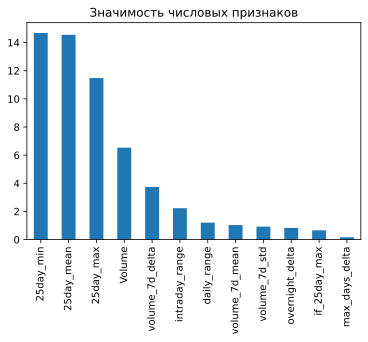

In [25]:
# Колонки с числовыми признаками.

num_cols = list(set(df.columns) - set(df.select_dtypes('object').columns))

num_cols.remove('Open')
num_cols.remove('Is_Train')

imp_num = pd.Series(f_classif(df[num_cols][df['Is_Train'] == 1],
                              df['Open'][df['Is_Train'] == 1]
                             )[0],
                             index = num_cols
)

imp_num.sort_values(ascending=False, inplace = True)

imp_num[(imp_num > 0) & (imp_num < 100)].plot(kind='bar', title='Значимость числовых признаков');

### 2.7 Рассчёт прибыли

В этой секции мы рассчитаем прибыльность 2 "наивных" стратегий инвестирования условного портфеля в 1 миллион долларов:
1. Вложить в начале тестового периода 1 миллион и посчитать прибыльность в конце.
2. Вкладывать каждый месяц (30 дней) равную долю портфеля в акции по актуальной цене.

По сравнению с отсчётной прибылью, прибыльность на основании предсказаний будем считать следующим образом:
1. Предскажем стоимость акции в будущем.
2. С интервалом в 5 дней (рабочая неделя) будем соответственно предсказаниям покупать (long sales) или продавать (short sales) акции.
3. Полученная разница нам будет соответственно увеличивать или уменьшать стоимость порфтеля.
4. В конце посчитаем прибыль в денежном выражении как разницу между портфелем к концу тествого периода и начальными 1 млн. долларов.

Для простоты рассчётов не будем брать во внимание трансакционные издержки, налоги и прочие сопутствующие расходы.

In [26]:
starting_price = train_data['Open'].iloc[-1]
ending_price = test_data['Open'].iloc[-1]

pl_dict['Базовая стратегия №1'] = PORTFOLIO * (ending_price / starting_price - 1)

print(f'Прибыль наивной стратегии инвестирования №1: ${int(round(pl_dict["Базовая стратегия №1"], 0))}')

Прибыль наивной стратегии инвестирования №1: $870652


In [27]:
portfolio = []
installment_count = int(len(test_data) / 30)
installment = PORTFOLIO / (installment_count)


for i in range(installment_count):
    cur_price = test_data['Open'].iloc[i * 30]
    portfolio.append(installment / cur_price)

    
pl_dict['Базовая стратегия №2'] = sum(portfolio) * ending_price - PORTFOLIO

print(f'Прибыль наивной стратегии инвестирования №2: ${int(round(pl_dict["Базовая стратегия №2"], 0))}')

Прибыль наивной стратегии инвестирования №2: $409864


#### Вывод

* В индексе - данные с 18.8.2016 по 27.6.2021 включительно с Yahoo! Finance.
* Пропуски отсутствуют.
* Все данные вещественного типа (с плавающей запятой).
* Корреляция - ожидаемо очень высокая между котировками, но отрицательная с объёмом торгов (Volume) - чем выше цены, тем ниже объём торгов.
* Из основного набора удалены признаки 'High', 'Low', 'Close', 'Adj Close'.
* Создана серия дополнительных признаков, которые нам пригодятся для дальнейшей работы.
* Набор также расширен значениями инсайдерской торговли акциями.
* Целевая переменная в полученном наборе - Open (цена при открытии торгов).
* Три самые существенные переменные в наборе - 25-дневный минимум, 25-дневный максимум, и кол-во дней с последнего минимального значения цены. 

---
## 3. "Наивная" модель на основе случайного блуждания (random walk)

Случайное блуждание: https://ru.wikipedia.org/wiki/%D0%A1%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%B5_%D0%B1%D0%BB%D1%83%D0%B6%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5

In [28]:
# Последняя точка открытия в тренировочном наборе - начальная точка для тестового.

starting_point = train_open[-1]
origin = [[starting_point]]


# Определяем остальные параметры

dims = 1
step_n = test_size
step_set = [-1, 0, 1]
step_shape = (step_n, dims)


# Симулируем "блуждание"

np.random.seed(RANDOM_SEED)
steps = np.random.choice(a=step_set, size=step_shape)
y_pred = np.concatenate([origin, steps]).cumsum(0)

Значение отклонения MAPE - Случайное блуждание: 23.36%


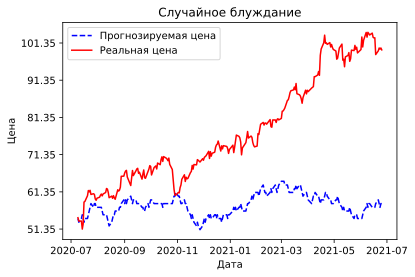

In [29]:
display_results(y_true, y_pred[1:], 'Случайное блуждание')

In [30]:
calc_profitability(y_true, y_pred[1:], 'Случайное блуждание')

Прибыльность стратегии Случайное блуждание: $73814


**Вывод**

Случайное блуждание, хоть и теоретически обосновано, показывает существенное отклонение в 23,36% от реальных значений.

---
## 4. Регрессия

### 4.1 Линейная регрессия

In [31]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(x_true)

Значение отклонения MAPE - Линейная регрессия: 3.67%


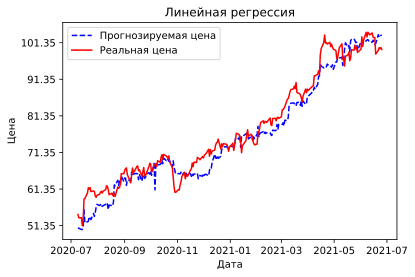

In [32]:
display_results(y_true, y_pred, 'Линейная регрессия')

In [33]:
calc_profitability(y_true, y_pred, 'Линейная регрессия')

Прибыльность стратегии Линейная регрессия: $1251162


### 4.2 CatBoostRegressor

In [34]:
model_cbr = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              silent=True
)

model_cbr.fit(X_train.values, y_train.values,
              eval_set=(X_test.values, y_test.values),
              verbose_eval=1000,
              use_best_model=True,
              plot=True
);

y_pred = model_cbr.predict(x_true.values)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1990515	test: 0.1194598	best: 0.1194598 (0)	total: 63.9ms	remaining: 5m 19s
1000:	learn: 0.0012503	test: 0.0602419	best: 0.0602348 (997)	total: 2.57s	remaining: 10.3s
2000:	learn: 0.0001907	test: 0.0601692	best: 0.0601638 (1671)	total: 5.35s	remaining: 8.02s
3000:	learn: 0.0000348	test: 0.0601652	best: 0.0601638 (1671)	total: 8.23s	remaining: 5.48s
4000:	learn: 0.0000074	test: 0.0601651	best: 0.0601638 (1671)	total: 12.4s	remaining: 3.09s
4999:	learn: 0.0000017	test: 0.0601651	best: 0.0601638 (1671)	total: 15.9s	remaining: 0us

bestTest = 0.06016376319
bestIteration = 1671

Shrink model to first 1672 iterations.


Значение отклонения MAPE - CatBoost регрессия: 17.25%


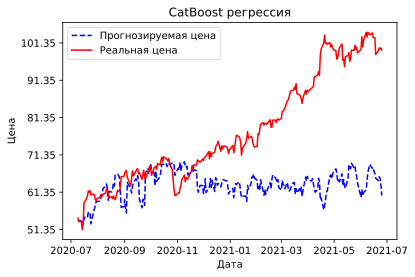

In [35]:
display_results(y_true, y_pred, 'CatBoost регрессия')

In [36]:
calc_profitability(y_true, y_pred, 'CatBoost регрессия')

Прибыльность стратегии CatBoost регрессия: $365599


### 4.3 Стекинг и кросс-валидация

In [37]:
# Модели линейной регрессии и CatBoost-регрессии переопределять не будем.

model_dtr = DecisionTreeRegressor(random_state=RANDOM_SEED)

model_rf = RandomForestRegressor(n_estimators=400, 
                                 random_state=RANDOM_SEED,
                                 n_jobs=-1
)

stack = StackingCVRegressor(regressors=(model_cbr, model_lr, model_dtr, model_rf),
                            meta_regressor=model_rf,
                            random_state=RANDOM_SEED
)


# Тренируем модель на стеке

stack.fit(X_train.values, y_train.values)

y_pred = stack.predict(x_true.values)

In [38]:
print(f'Кросс-валидационные оценки на {N_FOLDS}-фолдах:\n')

for clf, label in zip([model_cbr, model_lr, model_dtr, model_rf, stack],
                      ['CatBoost', 'Linear Regression', 'Decision Tree',
                       'Random Forest', 'StackingCVRegressor']):
    
    scores = cross_val_score(clf, X_train.values, y_train.values, cv=N_FOLDS, scoring=mape_scorer)
    print("MAPE: %0.3f (+/- %0.3f) [%s]" % 
          (scores.mean(), scores.std(), label)
    )

Кросс-валидационные оценки на 5-фолдах:

MAPE: -0.090 (+/- 0.054) [CatBoost]
MAPE: -0.049 (+/- 0.011) [Linear Regression]
MAPE: -0.109 (+/- 0.049) [Decision Tree]
MAPE: -0.092 (+/- 0.054) [Random Forest]
MAPE: -0.091 (+/- 0.054) [StackingCVRegressor]


Значение отклонения MAPE - Стекинг регрессивных моделей: 14.96%


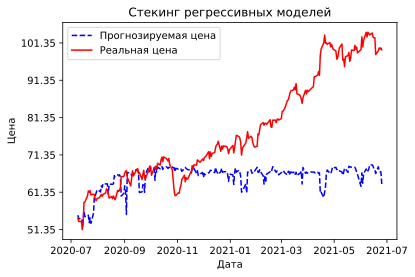

In [39]:
display_results(y_true, y_pred, 'Стекинг регрессивных моделей')

In [40]:
calc_profitability(y_true, y_pred, 'Стекинг регрессивных моделей')

Прибыльность стратегии Стекинг регрессивных моделей: $14179


**Вывод**

* Линейная регрессия показала самый лучший результат.
* У CatBoost регрессии результат был существенно хуже и по скорости обработки, и по точности.
* Использование стекинга на совокупности 4 разных моделей дало средний вариант.

---
## 5. Анализ временных рядов
Модели анализа и предсказания временных рядов для таких задач являются по определению одними из самых подходящих.

Рассмотрим 2 таких модели - одну, основанную на классическом подходе ARIMA, и вторую - Prophet, разработанную компанией Facebook.


### 5.1 ARIMA

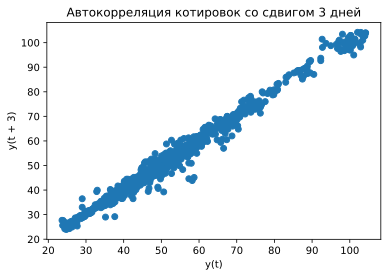

In [41]:
# Для начала проверим наличие автокорреляции

plt.figure()
pd.plotting.lag_plot(df['Open'], lag=3)
plt.title('Автокорреляция котировок со сдвигом 3 дней')
plt.show();

In [42]:
# Определим входные параметры - исторические значения котировок,
# список с предсказаниями и кол-во предсказываемых котировок.

history = [x for x in train_open]
y_pred = []
N_test_observations = len(test_open)


# Предсказываем будущие значения. Исп. параметры ARIMA: сдвиг(p) = 4
# дня, степень разницы(d) = 1, ширина окна скольз. среднего(q) = 0

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    y_pred.append(yhat)
    
    true_test_value = test_open[time_point]
    history.append(true_test_value)

Значение отклонения MAPE - ARIMA: 1.39%


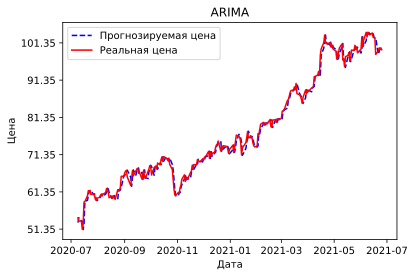

In [43]:
display_results(y_true, y_pred, 'ARIMA')

In [44]:
calc_profitability(y_true, y_pred, 'ARIMA')

Прибыльность стратегии ARIMA: $3118211


### 5.2 Facebook Prophet

Недавно Facebook предоставил на суд общественности модель Prophet, заточенную на предсказание временных рядов, с возможностью улавливать сезонность данных.

Математическая формула данной модели основана на следющем уравнении:

y(t) = g(t) + s(t) + h(t) + e(t)

где

 * g(t) представляет тренд - Prophet использует линейную модель для предсказания тренда;
 * s(t) предсказывает "регулярные" колебания (недельные, месячные, гододвые);
 * h(t) отражает влияние праздников;
 * e(t) остаточная ошибка модели.

In [45]:
# Преобразуем данные в формат, понятный модели Prophet.

prophet_train = pd.DataFrame()

prophet_train['y']  = train_open
prophet_train['ds'] = train_data.index
prophet_train.reset_index(drop=True, inplace=True)

prophet_train.head()

,y,ds
0,24.363234,2016-08-18
1,23.643412,2016-08-19
2,23.809525,2016-08-22
3,24.224806,2016-08-23
4,27.685493,2016-08-24


In [46]:
# Тренируем модель

m = Prophet(daily_seasonality=True)

m.fit(prophet_train);

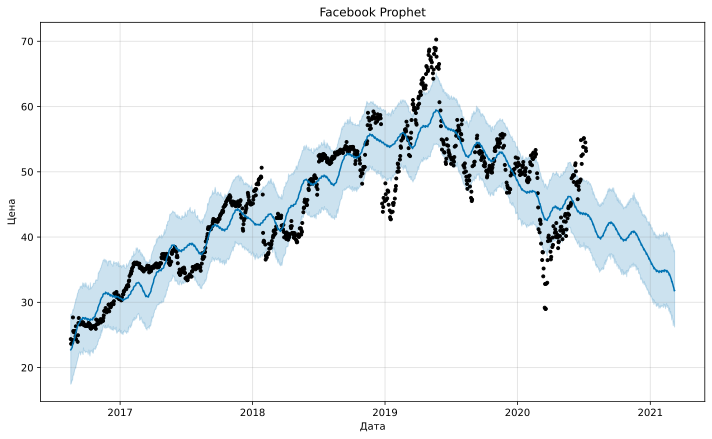

In [47]:
# Делаем предсказания

future = m.make_future_dataframe(periods=len(test_data))
prediction = m.predict(future)
y_pred = list(prediction['yhat'].iloc[-len(test_open):])


# Рисуем график предсказаний

m.plot(prediction)
plt.title('Facebook Prophet')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show();

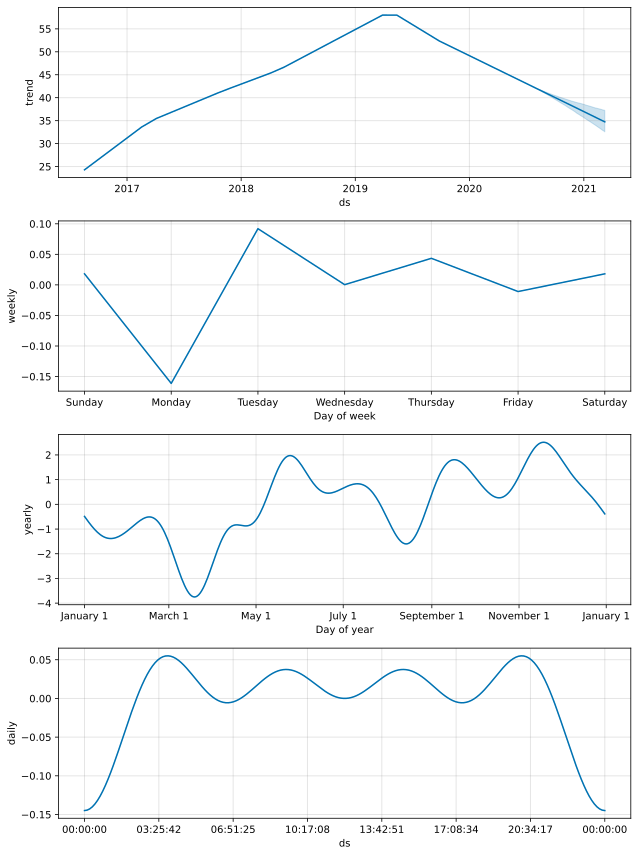

In [48]:
# Посмотрим также на разбивку по сезонным факторам, которые для себя определила модель.

m.plot_components(prediction)

plt.show();

Значение отклонения MAPE - Prophet: 47.57%


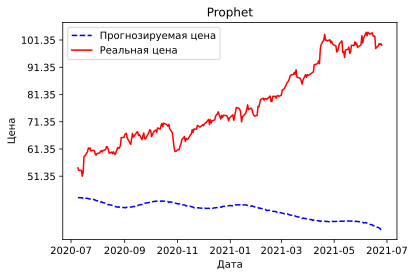

In [49]:
display_results(y_true, y_pred, 'Prophet')

In [50]:
calc_profitability(y_true, y_pred, 'Prophet')

Прибыльность стратегии Prophet: $-257239


**Вывод**

* ARIMA показала самый лучший результат из всех моделей.
* В отличие от Prophet - который из всех возможных моделей оказался на удивление самым неподходящим для данной задачи.
* То, что модель на основе временных рядов показала самый лучший варианта - вполне логично: котировки "привязаны" к значениям предыдущих дней и от них во многом зависят.
* То, что ARIMA показала хороший результат также является следствием того, что для предсказания будущих данных модель пользовалась данными со сдвигом 4 дней, опираясь на "самые свежие" данные, в отличие от других моделей, когда мы предсказывали результат "скопом" на все 244 дней используя только косвенные признаки набора и обучение, полученное на данных из прошлого.

---
## 6. Нейронные сети

Воспользуемся нейронной сетью типа LSTM, которая лучше всего подходит для предсказания временных рядов.

In [51]:
scaler = RobustScaler()

tf.random.set_seed(RANDOM_SEED)

In [52]:
# Определим вспомогательную функцию для предобработки данных

def make_dataset(df, window_size, batch_size, use_scaler=True):
    '''
        Функция для подготовки и предобработки датасета.
         - df - Pandas DataFrame с входными данными
         - window_size - окно сдвига
         - batch_size - размер выборки во временном ряде TF
         - use_scaler (по умолчанию True) - провести ли нормализацию данных
    '''
    features = df[['Open']].iloc[:-window_size]
    
    if use_scaler:
        features = scaler.fit_transform(features)
    
    data = np.array(features, dtype=np.float32)
    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=df['Open'].iloc[window_size:],
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=batch_size
    )
    
    return ds

In [53]:
# Предобработаем данные используя нашу функцию с размером окна сдвига = 10
# и размером выборки = 8. Также нормализируем наши фичи - НС это любят :)

window_size = 10
batch_size = 8

train_df = make_dataset(df=train_data,
                        window_size=window_size,
                        batch_size=batch_size,
                        use_scaler=True
)

test_df = make_dataset(df=test_data,
                       window_size=window_size,
                       batch_size=batch_size,
                       use_scaler=True
)

In [54]:
earlystop = tf.keras.callbacks.EarlyStopping( monitor='val_MAPE',
                                              patience=50,
                                              restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_MAPE',
                                                 factor=0.25,
                                                 patience=50,
                                                 min_lr=0.0000001,
                                                 verbose=0,
                                                 mode='auto'
)

callbacks_list = [earlystop, reduce_lr]

In [55]:
# Определяем и тренируем модель, а затем делаем с её помощью предсказания.

lstm_model = tf.keras.models.Sequential([
                                        tf.keras.layers.LSTM(32, return_sequences=True),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.LSTM(32, return_sequences=False),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(1)
])


lstm_model.compile(loss=tf.losses.MeanAbsolutePercentageError(),
                   optimizer=tf.optimizers.Adam(0.01),
                   metrics=[tf.metrics.MeanAbsolutePercentageError()]    
)


history = lstm_model.fit(train_df,
                         epochs=EPOCHS,
                         validation_data=test_df,
                         callbacks=callbacks_list,
                         verbose=0
)

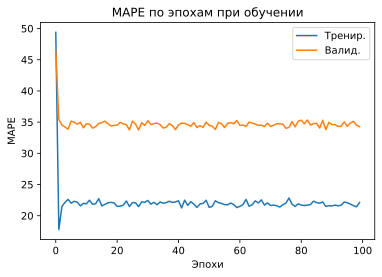

In [56]:
# Смотрим как обучалась наша модель.

plt.title('MAPE по эпохам при обучении')

plt.plot(history.history['mean_absolute_percentage_error'], label='Тренир.')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='Валид.')

plt.xlabel('Эпохи')
plt.ylabel('MAPE')

plt.legend()
plt.show();

In [57]:
print(f'Оценка MAPE на тренировочном наборе:')
lstm_model.evaluate(train_df)

print(f'\nОценка MAPE на проверочном наборе:')
lstm_model.evaluate(test_df)

Оценка MAPE на тренировочном наборе:
120/120 [==============================] - 1s 6ms/step - loss: 22.6161 - mean_absolute_percentage_error: 22.6161

Оценка MAPE на проверочном наборе:
29/29 [==============================] - 0s 5ms/step - loss: 34.2632 - mean_absolute_percentage_error: 34.2632


[34.26321029663086, 34.26321029663086]

**Вывод**

* К сожалению нейросеть оказалась непригодна для предсказания временных рядов на длинном горизонте.

---
## 7. Анализ "настроя" новостей из Твиттера с помощью NLP

Не секрет, что новости зачастую оказывают существенное воздействие на краткосрочные колебания котировок. Крупные инвестиционные банки и хедж-фонды обладают продвинутыми системами по сбору и анализу новостных данных. Такие системы позволяют улавливать моменты, когда изменения, опубликованные в новостях, ещё полностью не отражены в биржевых котировках, и вкупе с высокочастотным трейдингом получить прибыль за счёт быстрой оценки новостей и выставления соответствующих торговых позиций (напр. на продажу или, наоборот, на покупку акций).

В нашем проекте мы реализуем простую модель, которая соберёт новости из Твиттера с привязкой к датам, и произведёт оценку совокупного "настроя" твитов и на его основании спрогнозирует движение цены акции в последующий день.

In [58]:
# Определим вспомогательные функции по очистке и разбивке полученных данных.

def clean_tweet(tweet):
    '''
        Функция, получающая на вход строку и очищающая её
        с помощью регулярных выражений от лишнего "шума".
    '''
    whitespace = re.compile(r'\s+')
    web_address = re.compile(r'(?i)http(s):\/\/[a-z0-9.~_\-\/]+')
    comp = re.compile(r'(?i)@' + TICKER + '(?=\b)')
    user = re.compile(r'(?i)@[a-z0-9_]+')

    # we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = comp.sub(TICKER, tweet)
    tweet = user.sub('', tweet)
    
    return tweet



def get_data(tweet):
    '''
        Функция, получающая на вход строку из JSON вывода Твиттера
        и разбивающая её на соответствующие поля.
        Дополнительно вызывает функцию очистки текста твита от шума.
    '''
    data = {
            'id': tweet['id'],
            'created_at': tweet['created_at'],
            'text': clean_tweet(tweet['text'])
    }
    
    return data



dtformat = '%Y-%m-%dT%H:%M:%SZ'


def time_travel(now, mins):
    '''
        Функция для "смещения" временного окна, из которого
        качаются твиты.
        Используется для обхода ограничение Твиттера
        по одномоментно скачиваемым данным твитов в бесплатном
        доступе для разработчиков.
    '''
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    
    return back_in_time.strftime(dtformat)

In [59]:
# Подкачиваем входные данные для классификации текста в англ. языке.

sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2021-07-06 12:40:08,771 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp7gxymzh_


100%|██████████| 265512723/265512723 [00:17<00:00, 15373009.80B/s]

2021-07-06 12:40:26,611 copying /tmp/tmp7gxymzh_ to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-07-06 12:40:26,944 removing temp file /tmp/tmp7gxymzh_
2021-07-06 12:40:26,986 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [60]:
endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
        'query': '(' + TICKER + ' OR ' + TICKER + ' stock) (lang:en)',
        'max_results': '100',
        'tweet.fields': 'created_at,lang'
}

In [61]:
tweet_df = pd.DataFrame()

now = datetime.now() - timedelta(seconds=10)               # Точное время минус 10 секунд (ограничение Твиттера)
last_week = now - timedelta(days=6, hours=23, minutes=55)  # datetime 1 неделю назад: больше Твиттер забесплатно не даёт
now = now.strftime(dtformat)                               # Перевод в формат времени, который понимает API Твиттера
pre60 = time_travel(now, 60)                               # Смещаем на 60 минут до нынешней отметки времени (now)


while datetime.strptime(pre60, dtformat) >= last_week:
        
    # Определяем начало и конец скачиваемого фрагмента и после сдвигаем окно на 60 минут назад
    
    params['start_time'] = pre60
    params['end_time'] = now
    now = pre60
    
    
    # Качаем данные
    
    response = requests.get(endpoint,
                            params=params,
                            headers=headers
    )
    
    
    # Обрабатываем и дополняем в DataFrame очищенные твиты, пользуясь обработчиком ошибок.
    
    try:
        for tweet in response.json()['data']:
            row = get_data(tweet)
            tweet_df = tweet_df.append(row, ignore_index=True)
    
    except Exception as e:
        print(e)
        break
        
    pre60 = time_travel(now, 60)

In [62]:
print(tweet_df.shape)

tweet_df.sample(5)

(15933, 3)


,created_at,id,text
4840,2021-07-04T08:29:21.000Z,1411603021331460096,Nothing pending from my end Please...
2476,2021-07-05T10:32:00.000Z,1411996276355485697,RT : Earth's Survivors: Knock by Geo Dell Ther...
13059,2021-06-30T18:34:04.000Z,1410305654829436934,Dell’s New $200 Webcam Uses a Sony Low-Light C...
11896,2021-07-01T06:38:11.000Z,1410487881727197185,"Recently, #Vodafone selected #DellTech to prov..."
11057,2021-07-01T15:17:51.000Z,1410618659932839951,"RT : 🔥🔥🔥🔥Dell g3 4gb dedicated, 1Tb 8gb ram, c..."


In [63]:
# Списки "уверенности" модели и настроя (положительный / отрицательный),
# которые мы будет по одному оценивать и позже дополним в главный DataFrame твитов.

probs = []
sentiments = []
score = []


for tweet in tweet_df['text'].to_list():
    
    # Оцениваем твит и добавляем в соотв. список
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    
    prob = sentence.labels[0].score              # Оценка уверенности от 0 до 1
    sent = sentence.labels[0].value              # 'POSITIVE' или 'NEGATIVE'
    
    probs.append(prob)                       
    sentiments.append(sent)                  
    
    if sent == 'NEGATIVE':
        score.append(-1 * prob)
    else:
        score.append(prob)


# Дополним полученные оценки в DataFrame

tweet_df['probability'] = probs
tweet_df['sentiment']   = sentiments
tweet_df['score']       = score


# И посмотрим на выборку из 5 твитов и их оценок

tweet_df.sample(5)

,created_at,id,text,probability,sentiment,score
5640,2021-07-03T22:04:18.000Z,1411445723284058112,RT : 🎥| 🇮🇹: Harry mentre esulta al goal dell’I...,0.999519,POSITIVE,0.999519
11085,2021-07-01T15:12:50.000Z,1410617400161046532,RT : MeitY has approved 14 eligible applicants...,0.983941,POSITIVE,0.983941
1024,2021-07-06T01:50:37.000Z,1412227455423819777,Laptop. Failing RAM. Replaced. Funny business...,0.999942,NEGATIVE,-0.999942
13440,2021-06-30T15:13:25.000Z,1410255159079456786,RT : A worthwhile fundraiser for a headstone f...,0.964666,POSITIVE,0.964666
3091,2021-07-05T03:48:16.000Z,1411894674621599745,We could go completely overboard and replace o...,0.990134,POSITIVE,0.990134


In [64]:
# Внесём данные даты твитов в индекс и уберём время.

tweet_df['date'] = pd.to_datetime(tweet_df['created_at'])

tweet_df = tweet_df.set_index('date')

tweet_df.index = tweet_df.index.date

tweet_df.head()

,created_at,id,text,probability,sentiment,score
2021-07-06,2021-07-06T12:40:17.000Z,1412390948949090306,We've setup plenty of Dell Wyse all-in-one #th...,0.999487,POSITIVE,0.999487
2021-07-06,2021-07-06T12:40:04.000Z,1412390891864592384,Can I mine #Ethereum with a #Dell laptop? #Coi...,0.996616,POSITIVE,0.996616
2021-07-06,2021-07-06T12:39:29.000Z,1412390745248575488,#RSSfellows get a discount of up to 20% on lap...,0.982032,NEGATIVE,-0.982032
2021-07-06,2021-07-06T12:39:20.000Z,1412390708384763908,RT : Informative article on 's first partners ...,0.993058,POSITIVE,0.993058
2021-07-06,2021-07-06T12:39:07.000Z,1412390655582744579,"Happy Birthday to Dell, aka ! What's your favo...",0.997708,POSITIVE,0.997708


In [65]:
# Подсчитаем суммарный "настрой" по дням.

daily_scores = tweet_df.groupby(tweet_df.index)['score'].mean()

daily_scores

2021-06-29    0.405276
2021-06-30    0.353066
2021-07-01    0.395392
2021-07-02    0.451195
2021-07-03    0.467467
2021-07-04    0.401920
2021-07-05    0.474379
2021-07-06    0.488514
Name: score, dtype: float64

In [66]:
# Качаем сравнимые по детализации данные за последние 7 дней с поминутной частотой.

yesterday = (datetime.today() - timedelta(days=1)).strftime(format='%Y-%m-%d')
week_ago  = (datetime.today() - timedelta(days=7)).strftime(format='%Y-%m-%d')

df_min = yf.download(TICKER, week_ago, yesterday, interval='1m')

df_min.index = df_min.index.date


# Уберём данные за первый день из обоих наборов - он неполон в наборе твитов.

df_min = df_min.loc[df_min.index > daily_scores.index[0]]
daily_scores = np.array(daily_scores.iloc[1:])

print(df_min.shape[0], daily_scores.size)

[*********************100%***********************]  1 of 1 completed
1148 7


In [67]:
# Интерполируем данные "настроя", чтобы получить списки одинаковой длины.

old_indices = np.arange(0, len(daily_scores))
new_indices = np.linspace(0, len(daily_scores) - 1, df_min.shape[0])

spl = UnivariateSpline(old_indices, daily_scores, k=3, s=0)

daily_scores_new = spl(new_indices)

print(daily_scores_new.size)

1148


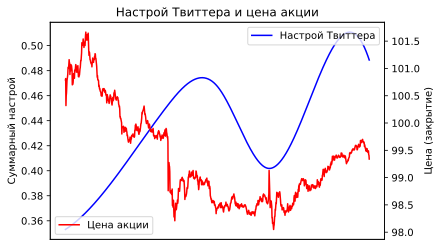

In [68]:
# Рисуем график, в котором наложим сглаженные данные "настроя" по дням на котировки акции.

fig, ax = plt.subplots()

ax.plot(daily_scores_new, color='blue', label='Настрой Твиттера')
ax.set_ylabel('Суммарный настрой')
ax.legend(loc=1)

ax2=ax.twinx()
ax2.plot(df_min['Adj Close'].values, color='red', label='Цена акции')
ax2.set_ylabel('Цена (закрытие)')
ax2.legend(loc=3)

plt.xticks([])
plt.title('Настрой Твиттера и цена акции')
plt.show();

**Вывод**

* Эксперимент получился интересным, но практической ценности на данном этапе он не имеет.
* В будущем имеет смысл сосредоточиться на:
    * б*о*льшем объёме истории (бесплатный API Твиттера имеет ограничение в 7 дней);
    * подборе именно финансовых новостей с подпиской на источники типа Reuters и Bloomberg, а также финансовых аналитиков, специализирующихся на данном секторе;
    * ранжированием источников в зависимости от точности их прогноза и / или влиянительности.

---

## 8. Итоги и выводы

* Получилось с нуля создать модель, которая с помощью различных подходов и техник скачивает и прогнозирует биржевые котировки.
* Как и было задумано, использовался предельно широкий спектр моделей и функций.
* Логично наилучшей моделью оказалась ARIMA, которая идеально подходит для прогнозирования временных рядов. Сдвиг в 4 дня и опора на свежие данные помогли ей гораздо лучше других моделей уловить краткосрочный тренд.
* Несмотря на линейную природу модели и предельно простую теорию, второй по успешности себя показала линейная регрессия.
* Парадоксально, но неуспешными оказались Prophet и нейронная сеть. Prophet возможно излишне сосредоточился на улавливании сезонности, которая редко присутствует на финансовых рынках, в особенности в период серьёзных изменений.
* Насчёт НС - можно в дальнейшем попробовать как другую архитектуру LSTM сетей, так и другие варианты RNN сетей, напр. GRU. Хотя скорее всего проблема оказалась в разной ситуации на рынках - сеть обучалась в основном на до-ковидных данных, а тестирование происходило на данных 2/3 последнего года, когда ситуация на рынках была существенно иной.
* Не получилось полностью "раскрыть потенциал" по использованию Твиттера в качестве источника общего настроя ("мудрость толпы"). Частично из-за ограничений, накладываемых на объём данных, как из Твиттера, так и котировок с минимальным окном в 1 минуту. Частично из-за чрезмерно широкого охвата новостей, напр. нередко в твитах попадались упоминания Делла в контексте используемого оборудования. 
* MAPE, получившееся в результате (от наилучшего к наихудшему):
    * ARIMA - 1,39%
    * Линейная регрессия - 3,67%
    * Стекинг (на основе регрессии) - 14,96%
    * CatBoost регрессия - 17,25%
    * Случайное блуждание ("наивная" модель) - 23,36%
    * Нейронная сеть на базе LSTM - 34,26%
    * Prophet - 47,57%
* Получившейся наилучший результат MAPE в 1,39% хоть и в целом неплох, в реальной жизни для краткосрочных операций слишком велик. В то же время предсказательная способность ARIMA существенно снизится, если предсказывать результаты на более долгий срок. Поэтому как вариант для долгосрочного инвестирования в нашем случае неплохо подойдёт линейная регрессия - как в виду её "стабильности", так и потому, что такая стратегия минимизирует трансакционные издержки.

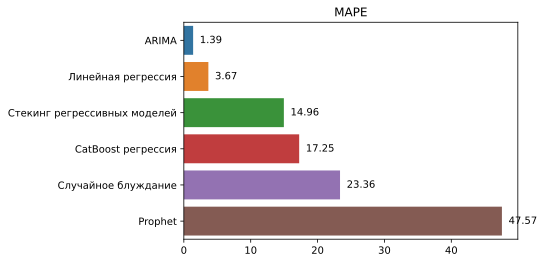

In [69]:
mape_dict = dict(sorted(mape_dict.items(), key=lambda item: item[1]))

mape_graph = sns.barplot(x=list(mape_dict.values()), y=list(mape_dict.keys()), orient='h')
mape_graph.set_title('MAPE')

for p in mape_graph.patches:
    width = p.get_width()                           # ширина полосы
    mape_graph.text(width + 1,                      # где будет значение
                    p.get_y() + p.get_height() / 2, # значение Y + X / 2
                    '{:1.2f}'.format(width),
                    ha = 'left',
                    va = 'center'
    )

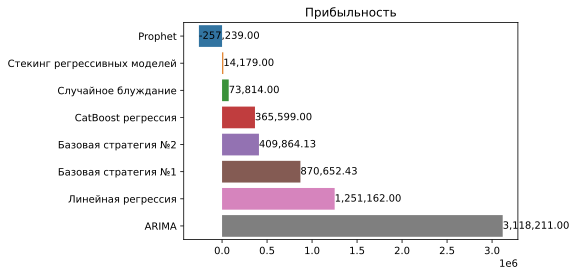

In [70]:
pl_dict = dict(sorted(pl_dict.items(), key=lambda item: item[1]))

pl_graph = sns.barplot(x=list(pl_dict.values()), y=list(pl_dict.keys()), orient='h')
pl_graph.set_title('Прибыльность')

for p in pl_graph.patches:
    width = p.get_width()                           # ширина полосы
    pl_graph.text(  width + 1,                      # где будет значение
                    p.get_y() + p.get_height() / 2, # значение Y + X / 2
                    '{:,.2f}'.format(width),
                    ha = 'left',
                    va = 'center'
    )